In [146]:
import pandas as pd
import numpy as np
import random
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Normalization, Input, Dense, Dropout
from keras.models import Sequential
from keras.initializers import glorot_uniform
from keras.regularizers import l2

In [118]:
url1 = "https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-/blob/main/Data/Data_10_genex.xlsx?raw=true"
url2 = "https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-/blob/main/Data/Table%2010.xlsx?raw=true"

gene_expression = pd.read_excel(url1)
patient_data = pd.read_excel(url2,index_col="Sample_ID")


In [197]:
def data_preprocessing(gene_expression, patient_data, var_of_interest, split = 0.75):

    gene_expression = gene_expression.T.iloc[:-2,:].sort_index().astype("float32")
    patient_data = patient_data[var_of_interest].sort_index()
    labels = np.sort(np.unique(patient_data))

    num_patients = gene_expression.shape[0]
    ind_shuffle = random.sample(list(range(num_patients)), num_patients)
    train_size = int(split*num_patients) 

    x_train = gene_expression.iloc[ind_shuffle][:train_size]
    y_train = patient_data.iloc[ind_shuffle][:train_size]

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_train)

    x_test = gene_expression.iloc[ind_shuffle][train_size:]
    y_test = patient_data.iloc[ind_shuffle][train_size:]

    #y_train = pd.get_dummies(y_train)
    #y_test = pd.get_dummies(y_test)

    y_train = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_train)]))
    y_test = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_test)]))

    if y_train.shape[1] != y_test.shape[1]:
        print("lol run again haha")

    return x_train, y_train, x_test, y_test, normalizer

In [139]:
def build_model(hid_layers, dropout, activation, L2, in_out_size, normalizer):

    model = Sequential()
    model.add(Input(shape=(in_out_size[0],)))
    model.add(normalizer)

    for i in range(len(hid_layers)-1):
        model.add(Dense(hid_layers[i],
                        activation = activation[i],
                        kernel_initializer=glorot_uniform(),
                        kernel_regularizer=l2(L2[i])
                        )
        )
        model.add(Dropout(dropout[i]))

    model.add(Dense(in_out_size[1],
              activation = activation[-1],
              kernel_initializer=glorot_uniform(),
              kernel_regularizer=l2(L2[-1])
              )
    )

    return model

In [166]:
def plot(history,size):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    x_axis = np.arange(1, len(history.history['accuracy'])+1)
    plt.plot(x_axis, history.history['accuracy'], label='training')
    plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    return 'plot'

4/4 [==============================] - 0s 4ms/step - loss: 0.1892 - accuracy: 0.9541


[0.18915043771266937, 0.9541284441947937]

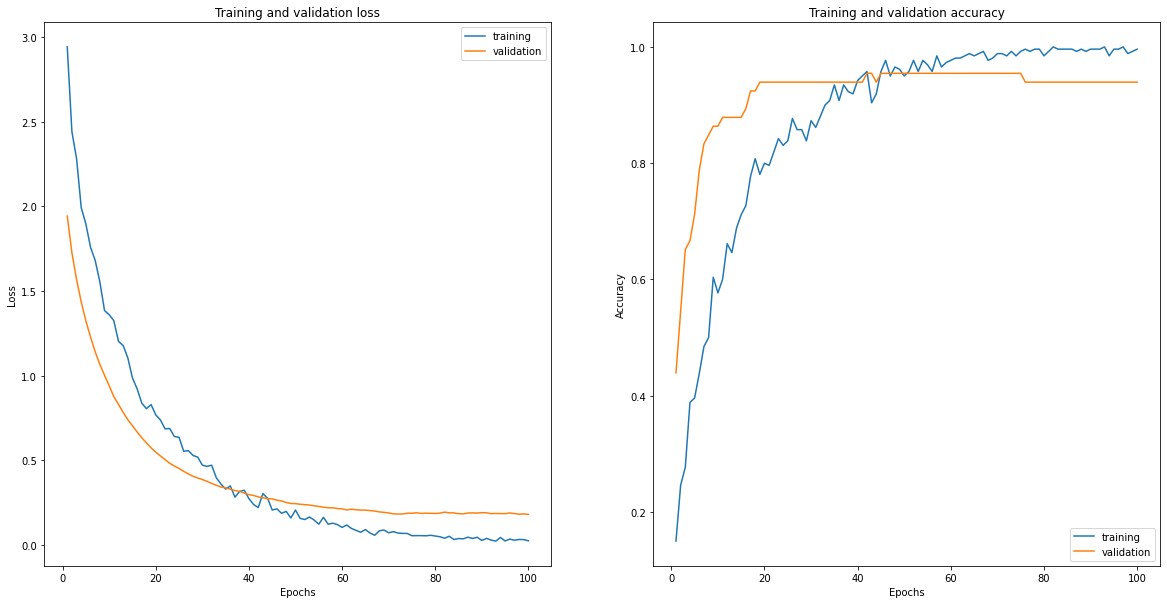

In [199]:
x_train, y_train, x_test, y_test, normalizer = data_preprocessing(gene_expression,
                                                                  patient_data,
                                                                  "Transcriptional_Identity")
hid_layers  = [512,256,128]
dropout     = [0.5,0.4,0.3]
activation  = ["relu","relu","relu","softmax"]
L2          = [0,0,0]
in_out_size = [x_train.shape[1],y_train.shape[1]]

model = build_model(hid_layers,
                    dropout,
                    activation,
                    L2,
                    in_out_size, 
                    normalizer)

model.compile(loss = "categorical_crossentropy", 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              metrics=["accuracy"])

history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    verbose=False,
                    batch_size=64, 
                    validation_split=0.2)

plot(history,10)
model.evaluate(x_test, y_test)